# A transformer-based model based on "What does self-attention learn from Masked Language Modelling?" paper

### Core parts of the transformer
- Separated position and spin
- Single attention layer


### Outline
1. Vanilla attention implementation
2. Factored attention implementation


In [529]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import seaborn as sns

from utils import *
from train import *

In [530]:
# Sequences for decoder
'''
dec_chains_train = np.load('data/2_spin/final_chains_T=1_num_iters=5_J_experiment_train_1.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('data/2_spin/final_chains_T=1_num_iters=5_J_experiment_test_1.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)
'''
dec_train_chains = np.load('data/data_dec_example_big.npy')
J = np.load("data/contact_mat/J_enc_big.npy")

#dec_train_chains = np.load('data/train_example_new.npy')
#J = np.load('data/contact_mat/J_example_new.npy')


TP fraction for mfDCA: (0, 0.0)


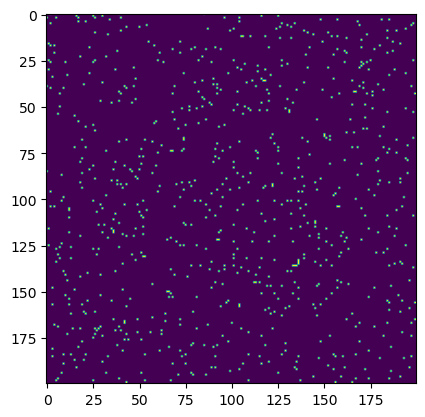

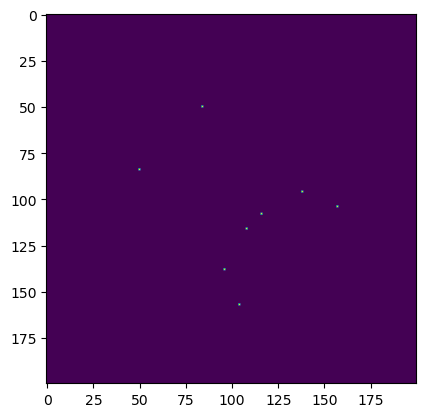

In [531]:
def plotting_heatmaps(initial_sequences, final_chains_train, title1, title2):
    # Set up a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a heatmap on each subplot
    sns.heatmap(initial_sequences, ax=ax1, cmap='viridis')
    ax1.set_title(title1)

    sns.heatmap(final_chains_train, ax=ax2, cmap='viridis')
    ax2.set_title(title2)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

# Calculate the number of true-positives
def calculate_true_positives(cov_inv, J):
    """
    Calculate the number of true positives.
    Args:
        cov_inv (np.array): Inverse covariance matrix.
        J (np.array): True interaction matrix.
    Returns:
        int: Number of true positives.
    """
    TP = 0
    num_positives = np.sum(J==1)
    for c, j in zip(cov_inv, J):
        if (c == j) and (c == 1):
            TP += 1
    return TP, TP/num_positives

def calculate_false_positives(cov_inv, J):
    """
    Calculate the number of false positives.
    Args:
        cov_inv (np.array): Inverse covariance matrix.
        J (np.array): True interaction matrix.
    Returns:
        int: Number of false positives.
    """
    FP = 0
    num_negatives = np.sum(J==0)
    for c, j in zip(cov_inv, J):
        if (c != j) and (c == 1):
            FP += 1
    return FP, FP/num_negatives

plt.imshow(J)
plt.figure()
#plt.imshow(dec_train_chains.T@dec_train_chains)
mfDCAmat = np.linalg.inv(dec_train_chains.T@dec_train_chains)
threshold_mf = np.percentile(mfDCAmat, 0.02)
binary_data_mf = np.where(mfDCAmat > threshold_mf, 0, 1)
np.fill_diagonal(binary_data_mf, 0)
plt.imshow(binary_data_mf)
print("TP fraction for mfDCA:", calculate_true_positives(np.linalg.inv(dec_train_chains.T@dec_train_chains).flatten(), J.flatten()))



In [532]:
#J_large = np.load("data/contact_mat/J_large.npy")
#dec_samples = np.load("data/train_large.npy")
#dec_samples = (dec_samples+1)/2
#print(dec_samples.shape)

In [533]:
batch_size = 32
train_loader = create_dataloaders(dec_train_chains[:500], batch_size)

In [534]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.word_embeddings = nn.Embedding(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a  # parameter controlling how important positions are
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)

        self.fc1 = nn.Linear(embed_dim, embed_dim)

        self.fc = nn.Linear(embed_dim, num_spins-1)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)

        batch_size, seq_length = s.shape

        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)

        x_val = self.word_embeddings(s) + self.a * position_embeddings
        x = self.word_embeddings(s) + position_embeddings
        
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x_val)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.embed_dim)  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)

        # Apply dropout and the final fully connected layer
        output = self.fc(torch.relu(self.fc1(self.dropout(attn_output))))
        #output = self.fc(self.dropout(attn_output))

        return output, scores



In [535]:
def train(model, train_loader, vocab, optimizer, criterion, num_epochs=300, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            #input_one_hot = one_hot_encoding_batch(data, vocab)
            optimizer.zero_grad()
            data_flat = data.flatten()
            data_flat = torch.Tensor([vocab[token.item()] for token in data_flat])
            data = torch.tensor(data_flat).reshape(data.shape[0], data.shape[1]).long()
            
            #mask one token in each sequence and return the masked sequence and the position of the masked token from scratch
            positions = torch.randint(0, data.shape[1], (data.shape[0], 1))
            masked_sequence = data.clone()
            masked_sequence[torch.arange(data.shape[0]), positions.squeeze(-1)] = 2
            masked_sequence = masked_sequence.long()
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            # Compute loss
            loss = criterion(prediction[torch.arange(data.shape[0]), positions], data[torch.arange(data.shape[0]), positions])
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            attention_weights.append(scores.detach().cpu().numpy())
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_loader)):.4f}')
        #eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        #print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
       #if eval_loss < best_eval_loss:
       #     return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [536]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,-1:0,1:1,2:2} 
L = 200
embedding_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [543]:
# Example usage:
a = 0
num_epochs=300
model = VanillaAttentionTransformer(embed_dim=embedding_dim, a=a, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, vocab, optimizer, criterion, num_epochs=num_epochs, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_80513/3610731036.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data_flat).reshape(data.shape[0], data.shape[1]).long()
  0%|          | 1/300 [00:01<07:33,  1.52s/it]

Epoch 1 | Train Loss: 0.7318


  1%|          | 2/300 [00:02<05:41,  1.15s/it]

Epoch 2 | Train Loss: 0.7021


  1%|          | 3/300 [00:03<05:07,  1.03s/it]

Epoch 3 | Train Loss: 0.7017


  1%|▏         | 4/300 [00:04<04:56,  1.00s/it]

Epoch 4 | Train Loss: 0.6961


  2%|▏         | 5/300 [00:05<05:00,  1.02s/it]

Epoch 5 | Train Loss: 0.7098


  2%|▏         | 6/300 [00:06<04:52,  1.01it/s]

Epoch 6 | Train Loss: 0.7060


  2%|▏         | 7/300 [00:07<04:45,  1.03it/s]

Epoch 7 | Train Loss: 0.7023


  3%|▎         | 8/300 [00:08<04:31,  1.07it/s]

Epoch 8 | Train Loss: 0.6891


  3%|▎         | 9/300 [00:08<04:24,  1.10it/s]

Epoch 9 | Train Loss: 0.7056


  3%|▎         | 10/300 [00:09<04:19,  1.12it/s]

Epoch 10 | Train Loss: 0.7059


  4%|▎         | 11/300 [00:10<04:14,  1.14it/s]

Epoch 11 | Train Loss: 0.7092


  4%|▍         | 12/300 [00:11<04:12,  1.14it/s]

Epoch 12 | Train Loss: 0.6987


  4%|▍         | 13/300 [00:12<04:13,  1.13it/s]

Epoch 13 | Train Loss: 0.7103


  5%|▍         | 14/300 [00:13<04:11,  1.14it/s]

Epoch 14 | Train Loss: 0.6959


  5%|▌         | 15/300 [00:14<04:06,  1.16it/s]

Epoch 15 | Train Loss: 0.7056


  5%|▌         | 16/300 [00:14<04:05,  1.16it/s]

Epoch 16 | Train Loss: 0.6937


  6%|▌         | 17/300 [00:15<04:03,  1.16it/s]

Epoch 17 | Train Loss: 0.6997


  6%|▌         | 18/300 [00:16<04:00,  1.17it/s]

Epoch 18 | Train Loss: 0.6994


  6%|▋         | 19/300 [00:17<03:56,  1.19it/s]

Epoch 19 | Train Loss: 0.6946


  7%|▋         | 20/300 [00:18<03:55,  1.19it/s]

Epoch 20 | Train Loss: 0.6968


  7%|▋         | 21/300 [00:19<03:54,  1.19it/s]

Epoch 21 | Train Loss: 0.6959


  7%|▋         | 22/300 [00:19<03:55,  1.18it/s]

Epoch 22 | Train Loss: 0.6933


  8%|▊         | 23/300 [00:20<03:54,  1.18it/s]

Epoch 23 | Train Loss: 0.6950


  8%|▊         | 24/300 [00:21<03:55,  1.17it/s]

Epoch 24 | Train Loss: 0.6947


  8%|▊         | 25/300 [00:22<03:53,  1.18it/s]

Epoch 25 | Train Loss: 0.6933


  9%|▊         | 26/300 [00:23<03:52,  1.18it/s]

Epoch 26 | Train Loss: 0.6938


  9%|▉         | 27/300 [00:24<03:49,  1.19it/s]

Epoch 27 | Train Loss: 0.6935


  9%|▉         | 28/300 [00:25<04:23,  1.03it/s]

Epoch 28 | Train Loss: 0.6934


 10%|▉         | 29/300 [00:26<04:12,  1.08it/s]

Epoch 29 | Train Loss: 0.6944


 10%|█         | 30/300 [00:27<04:03,  1.11it/s]

Epoch 30 | Train Loss: 0.6934


 10%|█         | 31/300 [00:27<03:56,  1.14it/s]

Epoch 31 | Train Loss: 0.6957


 11%|█         | 32/300 [00:28<03:53,  1.15it/s]

Epoch 32 | Train Loss: 0.6932


 11%|█         | 33/300 [00:29<03:51,  1.15it/s]

Epoch 33 | Train Loss: 0.6932


 11%|█▏        | 34/300 [00:30<03:51,  1.15it/s]

Epoch 34 | Train Loss: 0.6935


 12%|█▏        | 35/300 [00:31<03:49,  1.16it/s]

Epoch 35 | Train Loss: 0.6933


 12%|█▏        | 36/300 [00:32<03:46,  1.16it/s]

Epoch 36 | Train Loss: 0.6931


 12%|█▏        | 37/300 [00:33<03:45,  1.17it/s]

Epoch 37 | Train Loss: 0.6929


 13%|█▎        | 38/300 [00:33<03:43,  1.17it/s]

Epoch 38 | Train Loss: 0.6937


 13%|█▎        | 39/300 [00:34<03:42,  1.18it/s]

Epoch 39 | Train Loss: 0.6933


 13%|█▎        | 40/300 [00:35<03:40,  1.18it/s]

Epoch 40 | Train Loss: 0.6933


 14%|█▎        | 41/300 [00:36<03:39,  1.18it/s]

Epoch 41 | Train Loss: 0.6932


 14%|█▍        | 42/300 [00:37<03:38,  1.18it/s]

Epoch 42 | Train Loss: 0.6924


 14%|█▍        | 43/300 [00:38<03:36,  1.18it/s]

Epoch 43 | Train Loss: 0.6936


 15%|█▍        | 44/300 [00:39<03:36,  1.18it/s]

Epoch 44 | Train Loss: 0.6939


 15%|█▌        | 45/300 [00:39<03:35,  1.18it/s]

Epoch 45 | Train Loss: 0.6932


 15%|█▌        | 46/300 [00:41<04:14,  1.00s/it]

Epoch 46 | Train Loss: 0.6932


 16%|█▌        | 47/300 [00:42<04:04,  1.04it/s]

Epoch 47 | Train Loss: 0.6937


 16%|█▌        | 48/300 [00:42<03:56,  1.07it/s]

Epoch 48 | Train Loss: 0.6932


 16%|█▋        | 49/300 [00:43<03:50,  1.09it/s]

Epoch 49 | Train Loss: 0.6931


 17%|█▋        | 50/300 [00:44<03:46,  1.10it/s]

Epoch 50 | Train Loss: 0.6932


 17%|█▋        | 51/300 [00:45<03:42,  1.12it/s]

Epoch 51 | Train Loss: 0.6932


 17%|█▋        | 52/300 [00:46<03:38,  1.13it/s]

Epoch 52 | Train Loss: 0.6933


 18%|█▊        | 53/300 [00:47<03:39,  1.12it/s]

Epoch 53 | Train Loss: 0.6932


 18%|█▊        | 54/300 [00:48<03:37,  1.13it/s]

Epoch 54 | Train Loss: 0.6931


 18%|█▊        | 55/300 [00:49<03:33,  1.15it/s]

Epoch 55 | Train Loss: 0.6930


 19%|█▊        | 56/300 [00:49<03:31,  1.15it/s]

Epoch 56 | Train Loss: 0.6935


 19%|█▉        | 57/300 [00:50<03:30,  1.15it/s]

Epoch 57 | Train Loss: 0.6932


 19%|█▉        | 58/300 [00:51<03:32,  1.14it/s]

Epoch 58 | Train Loss: 0.6932


 20%|█▉        | 59/300 [00:52<03:30,  1.15it/s]

Epoch 59 | Train Loss: 0.6931


 20%|██        | 60/300 [00:53<03:29,  1.15it/s]

Epoch 60 | Train Loss: 0.6931


 20%|██        | 61/300 [00:54<03:28,  1.15it/s]

Epoch 61 | Train Loss: 0.6930


 21%|██        | 62/300 [00:55<03:25,  1.16it/s]

Epoch 62 | Train Loss: 0.6935


 21%|██        | 63/300 [00:56<03:24,  1.16it/s]

Epoch 63 | Train Loss: 0.6933


 21%|██▏       | 64/300 [00:56<03:30,  1.12it/s]

Epoch 64 | Train Loss: 0.6932


 22%|██▏       | 65/300 [00:58<04:07,  1.05s/it]

Epoch 65 | Train Loss: 0.6931


 22%|██▏       | 66/300 [00:59<03:53,  1.00it/s]

Epoch 66 | Train Loss: 0.6932


 22%|██▏       | 67/300 [01:00<03:43,  1.04it/s]

Epoch 67 | Train Loss: 0.6933


 23%|██▎       | 68/300 [01:01<03:36,  1.07it/s]

Epoch 68 | Train Loss: 0.6932


 23%|██▎       | 69/300 [01:01<03:29,  1.10it/s]

Epoch 69 | Train Loss: 0.6930


 23%|██▎       | 70/300 [01:02<03:24,  1.13it/s]

Epoch 70 | Train Loss: 0.6932


 24%|██▎       | 71/300 [01:03<03:20,  1.14it/s]

Epoch 71 | Train Loss: 0.6931


 24%|██▍       | 72/300 [01:04<03:18,  1.15it/s]

Epoch 72 | Train Loss: 0.6935


 24%|██▍       | 73/300 [01:05<03:15,  1.16it/s]

Epoch 73 | Train Loss: 0.6934


 25%|██▍       | 74/300 [01:06<03:12,  1.17it/s]

Epoch 74 | Train Loss: 0.6931


 25%|██▌       | 75/300 [01:06<03:11,  1.17it/s]

Epoch 75 | Train Loss: 0.6932


 25%|██▌       | 76/300 [01:07<03:11,  1.17it/s]

Epoch 76 | Train Loss: 0.6932


 26%|██▌       | 77/300 [01:08<03:10,  1.17it/s]

Epoch 77 | Train Loss: 0.6932


 26%|██▌       | 78/300 [01:09<03:09,  1.17it/s]

Epoch 78 | Train Loss: 0.6930


 26%|██▋       | 79/300 [01:10<03:11,  1.15it/s]

Epoch 79 | Train Loss: 0.6933


 27%|██▋       | 80/300 [01:11<03:09,  1.16it/s]

Epoch 80 | Train Loss: 0.6933


 27%|██▋       | 81/300 [01:12<03:07,  1.17it/s]

Epoch 81 | Train Loss: 0.6930


 27%|██▋       | 82/300 [01:12<03:06,  1.17it/s]

Epoch 82 | Train Loss: 0.6932


 28%|██▊       | 83/300 [01:13<03:05,  1.17it/s]

Epoch 83 | Train Loss: 0.6930


 28%|██▊       | 84/300 [01:14<03:04,  1.17it/s]

Epoch 84 | Train Loss: 0.6929


 28%|██▊       | 85/300 [01:15<03:03,  1.17it/s]

Epoch 85 | Train Loss: 0.6931


 29%|██▊       | 86/300 [01:16<03:01,  1.18it/s]

Epoch 86 | Train Loss: 0.6935


 29%|██▉       | 87/300 [01:17<03:01,  1.17it/s]

Epoch 87 | Train Loss: 0.6931


 29%|██▉       | 88/300 [01:18<03:00,  1.17it/s]

Epoch 88 | Train Loss: 0.6931


 30%|██▉       | 89/300 [01:18<03:00,  1.17it/s]

Epoch 89 | Train Loss: 0.6933


 30%|███       | 90/300 [01:19<02:59,  1.17it/s]

Epoch 90 | Train Loss: 0.6928


 30%|███       | 91/300 [01:20<02:58,  1.17it/s]

Epoch 91 | Train Loss: 0.6929


 31%|███       | 92/300 [01:21<03:28,  1.00s/it]

Epoch 92 | Train Loss: 0.6933


 31%|███       | 93/300 [01:22<03:21,  1.03it/s]

Epoch 93 | Train Loss: 0.6937


 31%|███▏      | 94/300 [01:23<03:14,  1.06it/s]

Epoch 94 | Train Loss: 0.6932


 32%|███▏      | 95/300 [01:24<03:14,  1.05it/s]

Epoch 95 | Train Loss: 0.6933


 32%|███▏      | 96/300 [01:25<03:18,  1.03it/s]

Epoch 96 | Train Loss: 0.6933


 32%|███▏      | 97/300 [01:26<03:13,  1.05it/s]

Epoch 97 | Train Loss: 0.6931


 33%|███▎      | 98/300 [01:27<03:06,  1.08it/s]

Epoch 98 | Train Loss: 0.6931


 33%|███▎      | 99/300 [01:28<03:06,  1.08it/s]

Epoch 99 | Train Loss: 0.6934


 33%|███▎      | 100/300 [01:29<03:01,  1.10it/s]

Epoch 100 | Train Loss: 0.6929


 34%|███▎      | 101/300 [01:30<02:58,  1.11it/s]

Epoch 101 | Train Loss: 0.6930


 34%|███▍      | 102/300 [01:31<03:24,  1.03s/it]

Epoch 102 | Train Loss: 0.6934


 34%|███▍      | 103/300 [01:32<03:15,  1.01it/s]

Epoch 103 | Train Loss: 0.6935


 35%|███▍      | 104/300 [01:33<03:07,  1.04it/s]

Epoch 104 | Train Loss: 0.6932


 35%|███▌      | 105/300 [01:34<03:01,  1.07it/s]

Epoch 105 | Train Loss: 0.6933


 35%|███▌      | 106/300 [01:35<02:57,  1.09it/s]

Epoch 106 | Train Loss: 0.6931


 36%|███▌      | 107/300 [01:35<02:53,  1.12it/s]

Epoch 107 | Train Loss: 0.6927


 36%|███▌      | 108/300 [01:36<02:50,  1.13it/s]

Epoch 108 | Train Loss: 0.6932


 36%|███▋      | 109/300 [01:37<02:47,  1.14it/s]

Epoch 109 | Train Loss: 0.6927


 37%|███▋      | 110/300 [01:38<02:47,  1.14it/s]

Epoch 110 | Train Loss: 0.6923


 37%|███▋      | 111/300 [01:39<02:44,  1.15it/s]

Epoch 111 | Train Loss: 0.6937


 37%|███▋      | 112/300 [01:40<02:43,  1.15it/s]

Epoch 112 | Train Loss: 0.6938


 38%|███▊      | 113/300 [01:41<02:41,  1.16it/s]

Epoch 113 | Train Loss: 0.6933


 38%|███▊      | 114/300 [01:41<02:39,  1.16it/s]

Epoch 114 | Train Loss: 0.6933


 38%|███▊      | 115/300 [01:42<02:40,  1.16it/s]

Epoch 115 | Train Loss: 0.6925


 39%|███▊      | 116/300 [01:43<02:38,  1.16it/s]

Epoch 116 | Train Loss: 0.6933


 39%|███▉      | 117/300 [01:44<02:38,  1.16it/s]

Epoch 117 | Train Loss: 0.6929


 39%|███▉      | 118/300 [01:45<02:38,  1.15it/s]

Epoch 118 | Train Loss: 0.6918


 40%|███▉      | 119/300 [01:46<02:39,  1.13it/s]

Epoch 119 | Train Loss: 0.6933


 40%|████      | 120/300 [01:47<02:38,  1.14it/s]

Epoch 120 | Train Loss: 0.6937


 40%|████      | 121/300 [01:48<02:37,  1.14it/s]

Epoch 121 | Train Loss: 0.6935


 41%|████      | 122/300 [01:48<02:35,  1.14it/s]

Epoch 122 | Train Loss: 0.6925


 41%|████      | 123/300 [01:49<02:35,  1.14it/s]

Epoch 123 | Train Loss: 0.6929


 41%|████▏     | 124/300 [01:50<02:36,  1.13it/s]

Epoch 124 | Train Loss: 0.6940


 42%|████▏     | 125/300 [01:51<02:33,  1.14it/s]

Epoch 125 | Train Loss: 0.6930


 42%|████▏     | 126/300 [01:52<02:31,  1.15it/s]

Epoch 126 | Train Loss: 0.6924


 42%|████▏     | 127/300 [01:53<02:30,  1.15it/s]

Epoch 127 | Train Loss: 0.6927


 43%|████▎     | 128/300 [01:54<02:28,  1.16it/s]

Epoch 128 | Train Loss: 0.6937


 43%|████▎     | 129/300 [01:55<02:27,  1.16it/s]

Epoch 129 | Train Loss: 0.6938


 43%|████▎     | 130/300 [01:55<02:27,  1.15it/s]

Epoch 130 | Train Loss: 0.6931


 44%|████▎     | 131/300 [01:56<02:26,  1.15it/s]

Epoch 131 | Train Loss: 0.6926


 44%|████▍     | 132/300 [01:57<02:25,  1.16it/s]

Epoch 132 | Train Loss: 0.6929


 44%|████▍     | 133/300 [01:58<02:24,  1.16it/s]

Epoch 133 | Train Loss: 0.6936


 45%|████▍     | 134/300 [01:59<02:23,  1.16it/s]

Epoch 134 | Train Loss: 0.6943


 45%|████▌     | 135/300 [02:00<02:23,  1.15it/s]

Epoch 135 | Train Loss: 0.6925


 45%|████▌     | 136/300 [02:01<02:22,  1.15it/s]

Epoch 136 | Train Loss: 0.6935


 46%|████▌     | 137/300 [02:01<02:21,  1.15it/s]

Epoch 137 | Train Loss: 0.6920


 46%|████▌     | 138/300 [02:03<02:48,  1.04s/it]

Epoch 138 | Train Loss: 0.6936


 46%|████▋     | 139/300 [02:04<02:40,  1.00it/s]

Epoch 139 | Train Loss: 0.6937


 47%|████▋     | 140/300 [02:05<02:33,  1.04it/s]

Epoch 140 | Train Loss: 0.6929


 47%|████▋     | 141/300 [02:06<02:28,  1.07it/s]

Epoch 141 | Train Loss: 0.6931


 47%|████▋     | 142/300 [02:07<02:44,  1.04s/it]

Epoch 142 | Train Loss: 0.6928


 48%|████▊     | 143/300 [02:08<02:36,  1.00it/s]

Epoch 143 | Train Loss: 0.6925


 48%|████▊     | 144/300 [02:09<02:27,  1.06it/s]

Epoch 144 | Train Loss: 0.6939


 48%|████▊     | 145/300 [02:09<02:22,  1.09it/s]

Epoch 145 | Train Loss: 0.6935


 49%|████▊     | 146/300 [02:10<02:20,  1.09it/s]

Epoch 146 | Train Loss: 0.6929


 49%|████▉     | 147/300 [02:11<02:17,  1.11it/s]

Epoch 147 | Train Loss: 0.6922


 49%|████▉     | 148/300 [02:12<02:14,  1.13it/s]

Epoch 148 | Train Loss: 0.6926


 50%|████▉     | 149/300 [02:13<02:12,  1.14it/s]

Epoch 149 | Train Loss: 0.6940


 50%|█████     | 150/300 [02:14<02:10,  1.15it/s]

Epoch 150 | Train Loss: 0.6925


 50%|█████     | 151/300 [02:15<02:08,  1.16it/s]

Epoch 151 | Train Loss: 0.6944


 51%|█████     | 152/300 [02:15<02:07,  1.16it/s]

Epoch 152 | Train Loss: 0.6938


 51%|█████     | 153/300 [02:16<02:06,  1.16it/s]

Epoch 153 | Train Loss: 0.6931


 51%|█████▏    | 154/300 [02:17<02:05,  1.16it/s]

Epoch 154 | Train Loss: 0.6934


 52%|█████▏    | 155/300 [02:18<02:04,  1.16it/s]

Epoch 155 | Train Loss: 0.6933


 52%|█████▏    | 156/300 [02:19<02:03,  1.16it/s]

Epoch 156 | Train Loss: 0.6932


 52%|█████▏    | 157/300 [02:20<02:03,  1.16it/s]

Epoch 157 | Train Loss: 0.6932


 53%|█████▎    | 158/300 [02:21<02:02,  1.16it/s]

Epoch 158 | Train Loss: 0.6932


 53%|█████▎    | 159/300 [02:22<02:05,  1.12it/s]

Epoch 159 | Train Loss: 0.6931


 53%|█████▎    | 160/300 [02:23<02:07,  1.10it/s]

Epoch 160 | Train Loss: 0.6932


 54%|█████▎    | 161/300 [02:23<02:05,  1.11it/s]

Epoch 161 | Train Loss: 0.6933


 54%|█████▍    | 162/300 [02:24<02:03,  1.12it/s]

Epoch 162 | Train Loss: 0.6931


 54%|█████▍    | 163/300 [02:25<02:03,  1.11it/s]

Epoch 163 | Train Loss: 0.6932


 55%|█████▍    | 164/300 [02:26<02:03,  1.10it/s]

Epoch 164 | Train Loss: 0.6933


 55%|█████▌    | 165/300 [02:27<02:01,  1.11it/s]

Epoch 165 | Train Loss: 0.6931


 55%|█████▌    | 166/300 [02:28<01:58,  1.13it/s]

Epoch 166 | Train Loss: 0.6932


 56%|█████▌    | 167/300 [02:29<01:56,  1.14it/s]

Epoch 167 | Train Loss: 0.6931


 56%|█████▌    | 168/300 [02:30<01:55,  1.15it/s]

Epoch 168 | Train Loss: 0.6920


 56%|█████▋    | 169/300 [02:30<01:54,  1.14it/s]

Epoch 169 | Train Loss: 0.6940


 57%|█████▋    | 170/300 [02:31<01:52,  1.15it/s]

Epoch 170 | Train Loss: 0.6940


 57%|█████▋    | 171/300 [02:32<01:51,  1.16it/s]

Epoch 171 | Train Loss: 0.6932


 57%|█████▋    | 172/300 [02:33<01:50,  1.16it/s]

Epoch 172 | Train Loss: 0.6937


 58%|█████▊    | 173/300 [02:34<01:49,  1.16it/s]

Epoch 173 | Train Loss: 0.6932


 58%|█████▊    | 174/300 [02:35<01:49,  1.16it/s]

Epoch 174 | Train Loss: 0.6932


 58%|█████▊    | 175/300 [02:36<01:48,  1.16it/s]

Epoch 175 | Train Loss: 0.6932


 59%|█████▊    | 176/300 [02:36<01:46,  1.16it/s]

Epoch 176 | Train Loss: 0.6932


 59%|█████▉    | 177/300 [02:37<01:46,  1.16it/s]

Epoch 177 | Train Loss: 0.6933


 59%|█████▉    | 178/300 [02:38<01:45,  1.16it/s]

Epoch 178 | Train Loss: 0.6932


 60%|█████▉    | 179/300 [02:39<01:58,  1.02it/s]

Epoch 179 | Train Loss: 0.6934


 60%|██████    | 180/300 [02:40<01:54,  1.05it/s]

Epoch 180 | Train Loss: 0.6931


 60%|██████    | 181/300 [02:41<01:50,  1.08it/s]

Epoch 181 | Train Loss: 0.6931


 61%|██████    | 182/300 [02:42<02:02,  1.04s/it]

Epoch 182 | Train Loss: 0.6921


 61%|██████    | 183/300 [02:43<01:54,  1.02it/s]

Epoch 183 | Train Loss: 0.6931


 61%|██████▏   | 184/300 [02:44<01:49,  1.06it/s]

Epoch 184 | Train Loss: 0.6933


 62%|██████▏   | 185/300 [02:45<01:46,  1.08it/s]

Epoch 185 | Train Loss: 0.6933


 62%|██████▏   | 186/300 [02:46<01:43,  1.10it/s]

Epoch 186 | Train Loss: 0.6933


 62%|██████▏   | 187/300 [02:47<01:40,  1.12it/s]

Epoch 187 | Train Loss: 0.6934


 63%|██████▎   | 188/300 [02:48<01:38,  1.13it/s]

Epoch 188 | Train Loss: 0.6934


 63%|██████▎   | 189/300 [02:49<01:37,  1.14it/s]

Epoch 189 | Train Loss: 0.6932


 63%|██████▎   | 190/300 [02:49<01:35,  1.15it/s]

Epoch 190 | Train Loss: 0.6934


 64%|██████▎   | 191/300 [02:50<01:34,  1.15it/s]

Epoch 191 | Train Loss: 0.6932


 64%|██████▍   | 192/300 [02:51<01:33,  1.15it/s]

Epoch 192 | Train Loss: 0.6932


 64%|██████▍   | 193/300 [02:52<01:32,  1.16it/s]

Epoch 193 | Train Loss: 0.6932


 65%|██████▍   | 194/300 [02:53<01:31,  1.16it/s]

Epoch 194 | Train Loss: 0.6932


 65%|██████▌   | 195/300 [02:54<01:30,  1.16it/s]

Epoch 195 | Train Loss: 0.6932


 65%|██████▌   | 196/300 [02:55<01:28,  1.17it/s]

Epoch 196 | Train Loss: 0.6931


 66%|██████▌   | 197/300 [02:55<01:28,  1.17it/s]

Epoch 197 | Train Loss: 0.6928


 66%|██████▌   | 198/300 [02:56<01:27,  1.17it/s]

Epoch 198 | Train Loss: 0.6928


 66%|██████▋   | 199/300 [02:57<01:26,  1.17it/s]

Epoch 199 | Train Loss: 0.6935


 67%|██████▋   | 200/300 [02:58<01:25,  1.17it/s]

Epoch 200 | Train Loss: 0.6939


 67%|██████▋   | 201/300 [02:59<01:24,  1.17it/s]

Epoch 201 | Train Loss: 0.6933


 67%|██████▋   | 202/300 [03:00<01:24,  1.16it/s]

Epoch 202 | Train Loss: 0.6930


 68%|██████▊   | 203/300 [03:01<01:23,  1.16it/s]

Epoch 203 | Train Loss: 0.6932


 68%|██████▊   | 204/300 [03:01<01:22,  1.17it/s]

Epoch 204 | Train Loss: 0.6931


 68%|██████▊   | 205/300 [03:02<01:21,  1.16it/s]

Epoch 205 | Train Loss: 0.6935


 69%|██████▊   | 206/300 [03:03<01:20,  1.16it/s]

Epoch 206 | Train Loss: 0.6932


 69%|██████▉   | 207/300 [03:04<01:20,  1.16it/s]

Epoch 207 | Train Loss: 0.6931


 69%|██████▉   | 208/300 [03:05<01:19,  1.16it/s]

Epoch 208 | Train Loss: 0.6926


 70%|██████▉   | 209/300 [03:06<01:18,  1.16it/s]

Epoch 209 | Train Loss: 0.6932


 70%|███████   | 210/300 [03:07<01:17,  1.16it/s]

Epoch 210 | Train Loss: 0.6927


 70%|███████   | 211/300 [03:07<01:16,  1.16it/s]

Epoch 211 | Train Loss: 0.6928


 71%|███████   | 212/300 [03:08<01:17,  1.13it/s]

Epoch 212 | Train Loss: 0.6938


 71%|███████   | 213/300 [03:09<01:16,  1.14it/s]

Epoch 213 | Train Loss: 0.6945


 71%|███████▏  | 214/300 [03:10<01:15,  1.15it/s]

Epoch 214 | Train Loss: 0.6925


 72%|███████▏  | 215/300 [03:11<01:14,  1.15it/s]

Epoch 215 | Train Loss: 0.6933


 72%|███████▏  | 216/300 [03:12<01:23,  1.01it/s]

Epoch 216 | Train Loss: 0.6930


 72%|███████▏  | 217/300 [03:13<01:18,  1.06it/s]

Epoch 217 | Train Loss: 0.6936


 73%|███████▎  | 218/300 [03:14<01:15,  1.09it/s]

Epoch 218 | Train Loss: 0.6932


 73%|███████▎  | 219/300 [03:15<01:12,  1.11it/s]

Epoch 219 | Train Loss: 0.6927


 73%|███████▎  | 220/300 [03:16<01:11,  1.12it/s]

Epoch 220 | Train Loss: 0.6932


 74%|███████▎  | 221/300 [03:16<01:09,  1.14it/s]

Epoch 221 | Train Loss: 0.6926


 74%|███████▍  | 222/300 [03:17<01:07,  1.15it/s]

Epoch 222 | Train Loss: 0.6931


 74%|███████▍  | 223/300 [03:18<01:06,  1.15it/s]

Epoch 223 | Train Loss: 0.6920


 75%|███████▍  | 224/300 [03:19<01:06,  1.15it/s]

Epoch 224 | Train Loss: 0.6933


 75%|███████▌  | 225/300 [03:20<01:04,  1.16it/s]

Epoch 225 | Train Loss: 0.6921


 75%|███████▌  | 226/300 [03:21<01:15,  1.02s/it]

Epoch 226 | Train Loss: 0.6932


 76%|███████▌  | 227/300 [03:22<01:11,  1.02it/s]

Epoch 227 | Train Loss: 0.6927


 76%|███████▌  | 228/300 [03:23<01:08,  1.05it/s]

Epoch 228 | Train Loss: 0.6919


 76%|███████▋  | 229/300 [03:24<01:06,  1.08it/s]

Epoch 229 | Train Loss: 0.6933


 77%|███████▋  | 230/300 [03:25<01:03,  1.10it/s]

Epoch 230 | Train Loss: 0.6922


 77%|███████▋  | 231/300 [03:26<01:01,  1.11it/s]

Epoch 231 | Train Loss: 0.6940


 77%|███████▋  | 232/300 [03:27<01:00,  1.13it/s]

Epoch 232 | Train Loss: 0.6928


 78%|███████▊  | 233/300 [03:27<00:58,  1.14it/s]

Epoch 233 | Train Loss: 0.6927


 78%|███████▊  | 234/300 [03:28<00:57,  1.14it/s]

Epoch 234 | Train Loss: 0.6923


 78%|███████▊  | 235/300 [03:29<00:56,  1.15it/s]

Epoch 235 | Train Loss: 0.6929


 79%|███████▊  | 236/300 [03:30<00:55,  1.15it/s]

Epoch 236 | Train Loss: 0.6939


 79%|███████▉  | 237/300 [03:31<00:54,  1.15it/s]

Epoch 237 | Train Loss: 0.6933


 79%|███████▉  | 238/300 [03:32<00:54,  1.15it/s]

Epoch 238 | Train Loss: 0.6925


 80%|███████▉  | 239/300 [03:33<00:53,  1.14it/s]

Epoch 239 | Train Loss: 0.6927


 80%|████████  | 240/300 [03:34<00:52,  1.15it/s]

Epoch 240 | Train Loss: 0.6936


 80%|████████  | 241/300 [03:34<00:51,  1.14it/s]

Epoch 241 | Train Loss: 0.6943


 81%|████████  | 242/300 [03:35<00:50,  1.14it/s]

Epoch 242 | Train Loss: 0.6945


 81%|████████  | 243/300 [03:36<00:49,  1.14it/s]

Epoch 243 | Train Loss: 0.6921


 81%|████████▏ | 244/300 [03:37<00:48,  1.14it/s]

Epoch 244 | Train Loss: 0.6935


 82%|████████▏ | 245/300 [03:38<00:47,  1.15it/s]

Epoch 245 | Train Loss: 0.6922


 82%|████████▏ | 246/300 [03:39<00:46,  1.15it/s]

Epoch 246 | Train Loss: 0.6932


 82%|████████▏ | 247/300 [03:40<00:45,  1.15it/s]

Epoch 247 | Train Loss: 0.6926


 83%|████████▎ | 248/300 [03:40<00:45,  1.16it/s]

Epoch 248 | Train Loss: 0.6930


 83%|████████▎ | 249/300 [03:41<00:44,  1.16it/s]

Epoch 249 | Train Loss: 0.6941


 83%|████████▎ | 250/300 [03:42<00:43,  1.16it/s]

Epoch 250 | Train Loss: 0.6924


 84%|████████▎ | 251/300 [03:43<00:42,  1.15it/s]

Epoch 251 | Train Loss: 0.6931


 84%|████████▍ | 252/300 [03:44<00:41,  1.14it/s]

Epoch 252 | Train Loss: 0.6928


 84%|████████▍ | 253/300 [03:46<00:50,  1.08s/it]

Epoch 253 | Train Loss: 0.6945


 85%|████████▍ | 254/300 [03:46<00:47,  1.02s/it]

Epoch 254 | Train Loss: 0.6926


 85%|████████▌ | 255/300 [03:47<00:43,  1.03it/s]

Epoch 255 | Train Loss: 0.6934


 85%|████████▌ | 256/300 [03:48<00:41,  1.06it/s]

Epoch 256 | Train Loss: 0.6925


 86%|████████▌ | 257/300 [03:49<00:39,  1.09it/s]

Epoch 257 | Train Loss: 0.6933


 86%|████████▌ | 258/300 [03:50<00:38,  1.10it/s]

Epoch 258 | Train Loss: 0.6934


 86%|████████▋ | 259/300 [03:51<00:36,  1.11it/s]

Epoch 259 | Train Loss: 0.6938


 87%|████████▋ | 260/300 [03:52<00:35,  1.13it/s]

Epoch 260 | Train Loss: 0.6919


 87%|████████▋ | 261/300 [03:52<00:34,  1.14it/s]

Epoch 261 | Train Loss: 0.6936


 87%|████████▋ | 262/300 [03:53<00:33,  1.15it/s]

Epoch 262 | Train Loss: 0.6933


 88%|████████▊ | 263/300 [03:54<00:32,  1.15it/s]

Epoch 263 | Train Loss: 0.6925


 88%|████████▊ | 264/300 [03:55<00:31,  1.16it/s]

Epoch 264 | Train Loss: 0.6933


 88%|████████▊ | 265/300 [03:56<00:30,  1.16it/s]

Epoch 265 | Train Loss: 0.6931


 89%|████████▊ | 266/300 [03:57<00:29,  1.16it/s]

Epoch 266 | Train Loss: 0.6929


 89%|████████▉ | 267/300 [03:58<00:28,  1.16it/s]

Epoch 267 | Train Loss: 0.6938


 89%|████████▉ | 268/300 [03:59<00:27,  1.15it/s]

Epoch 268 | Train Loss: 0.6918


 90%|████████▉ | 269/300 [04:00<00:32,  1.04s/it]

Epoch 269 | Train Loss: 0.6903


 90%|█████████ | 270/300 [04:01<00:30,  1.01s/it]

Epoch 270 | Train Loss: 0.6925


 90%|█████████ | 271/300 [04:02<00:28,  1.03it/s]

Epoch 271 | Train Loss: 0.6956


 91%|█████████ | 272/300 [04:03<00:26,  1.06it/s]

Epoch 272 | Train Loss: 0.6913


 91%|█████████ | 273/300 [04:04<00:24,  1.08it/s]

Epoch 273 | Train Loss: 0.6932


 91%|█████████▏| 274/300 [04:04<00:23,  1.10it/s]

Epoch 274 | Train Loss: 0.6936


 92%|█████████▏| 275/300 [04:05<00:22,  1.11it/s]

Epoch 275 | Train Loss: 0.6932


 92%|█████████▏| 276/300 [04:06<00:21,  1.12it/s]

Epoch 276 | Train Loss: 0.6951


 92%|█████████▏| 277/300 [04:07<00:20,  1.13it/s]

Epoch 277 | Train Loss: 0.6938


 93%|█████████▎| 278/300 [04:08<00:19,  1.13it/s]

Epoch 278 | Train Loss: 0.6935


 93%|█████████▎| 279/300 [04:09<00:18,  1.15it/s]

Epoch 279 | Train Loss: 0.6935


 93%|█████████▎| 280/300 [04:10<00:17,  1.16it/s]

Epoch 280 | Train Loss: 0.6926


 94%|█████████▎| 281/300 [04:10<00:16,  1.16it/s]

Epoch 281 | Train Loss: 0.6930


 94%|█████████▍| 282/300 [04:11<00:15,  1.14it/s]

Epoch 282 | Train Loss: 0.6930


 94%|█████████▍| 283/300 [04:12<00:14,  1.15it/s]

Epoch 283 | Train Loss: 0.6926


 95%|█████████▍| 284/300 [04:13<00:13,  1.16it/s]

Epoch 284 | Train Loss: 0.6926


 95%|█████████▌| 285/300 [04:14<00:12,  1.16it/s]

Epoch 285 | Train Loss: 0.6913


 95%|█████████▌| 286/300 [04:15<00:12,  1.16it/s]

Epoch 286 | Train Loss: 0.6931


 96%|█████████▌| 287/300 [04:16<00:11,  1.16it/s]

Epoch 287 | Train Loss: 0.6951


 96%|█████████▌| 288/300 [04:17<00:10,  1.16it/s]

Epoch 288 | Train Loss: 0.6930


 96%|█████████▋| 289/300 [04:17<00:09,  1.15it/s]

Epoch 289 | Train Loss: 0.6939


 97%|█████████▋| 290/300 [04:18<00:08,  1.16it/s]

Epoch 290 | Train Loss: 0.6930


 97%|█████████▋| 291/300 [04:19<00:07,  1.16it/s]

Epoch 291 | Train Loss: 0.6925


 97%|█████████▋| 292/300 [04:20<00:06,  1.17it/s]

Epoch 292 | Train Loss: 0.6920


 98%|█████████▊| 293/300 [04:21<00:06,  1.02it/s]

Epoch 293 | Train Loss: 0.6941


 98%|█████████▊| 294/300 [04:22<00:05,  1.06it/s]

Epoch 294 | Train Loss: 0.6928


 98%|█████████▊| 295/300 [04:23<00:04,  1.09it/s]

Epoch 295 | Train Loss: 0.6941


 99%|█████████▊| 296/300 [04:24<00:03,  1.11it/s]

Epoch 296 | Train Loss: 0.6931


 99%|█████████▉| 297/300 [04:25<00:02,  1.12it/s]

Epoch 297 | Train Loss: 0.6934


 99%|█████████▉| 298/300 [04:26<00:01,  1.13it/s]

Epoch 298 | Train Loss: 0.6928


100%|█████████▉| 299/300 [04:26<00:00,  1.14it/s]

Epoch 299 | Train Loss: 0.6933


Epoch 300 | Train Loss: 0.6932


In [544]:
def calculate_true_positives(cov_inv, J):
    """
    Calculate the number of true positives.
    Args:
        cov_inv (np.array): Inverse covariance matrix.
        J (np.array): True interaction matrix.
    Returns:
        int: Number of true positives.
    """
    TP = 0
    FP = 0
    for c, j in zip(cov_inv, J):
        if (c == j) and (c == 1):
            TP += 1
        elif (c != j) and (c == 1):
            FP += 1
    if TP+FP==0:
        return TP, 0
    return TP, TP/(TP+FP)

Text(0.5, 1.0, 'Attention weights (a=0), TP=0.024')

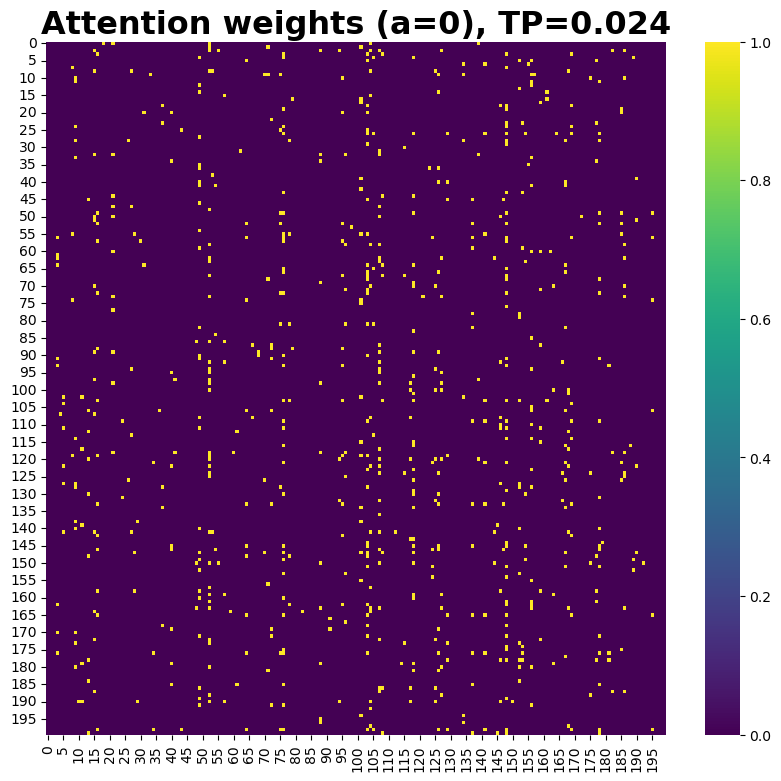

In [545]:
weights = attn_weights[-1].mean(axis=0)
threshold_mi = np.percentile(weights, 98)
weights = np.where(weights > threshold_mi, 1, 0)
np.fill_diagonal(weights, 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
sns.heatmap(weights, ax=ax, cmap='viridis')
ax.set_title(f"Attention weights (a={a}), TP={np.round(calculate_true_positives(weights.flatten(), J.flatten())[1], 3)}", fontweight="bold", size=23)

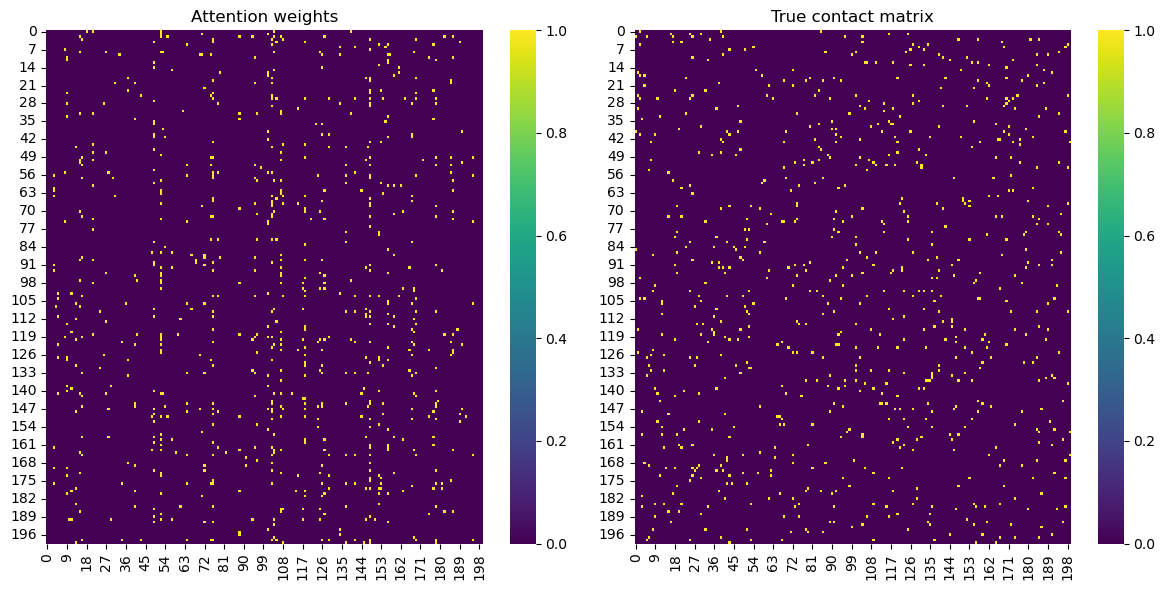

(19, 0.02402022756005057)
(772, 0.01969387755102041)


In [546]:
weights = attn_weights[-1].mean(axis=0)
threshold_mi = np.percentile(weights, 98)
weights = np.where(weights > threshold_mi, 1, 0)
np.fill_diagonal(weights, 0)
plotting_heatmaps(weights, J, "Attention weights", "True contact matrix")
print(calculate_true_positives(weights.flatten(), J.flatten()))
print(calculate_false_positives(weights.flatten(), J.flatten()))

In [384]:
# To save only the decoder layer weights
attn_weights = torch.vstack(attn_weights)
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(dec_chains_test.shape)

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

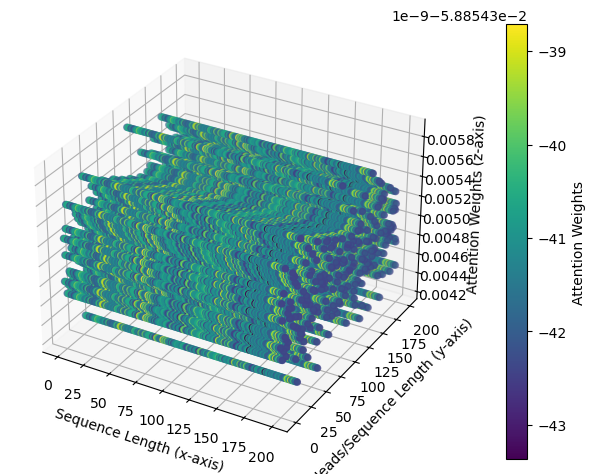

In [114]:
# loading self-attention weights)
caw = decoder_weights.mean(0).cpu().detach().numpy()

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Transpose the meshgrid to match the shape of attention_weights
x = x.T
y = y.T

# Flatten the x, y, and z (attention_weights) for plotting
x = x.flatten()
y = y.flatten()
z = caw.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap
# third distribution is more aligned one
sc = ax.scatter(x, y, z, c=np.dot(caw,dec_chains_test[:200,:]), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Attention Weights')

# Labels
ax.set_xlabel('Sequence Length (x-axis)')
ax.set_ylabel('Heads/Sequence Length (y-axis)')
ax.set_zlabel('Attention Weights (z-axis)')


plt.tight_layout()
plt.show()


### Determine the J from the decoder weights
Ideas:
- To achieve that we set the negative weights equal to 0 and positive to 1

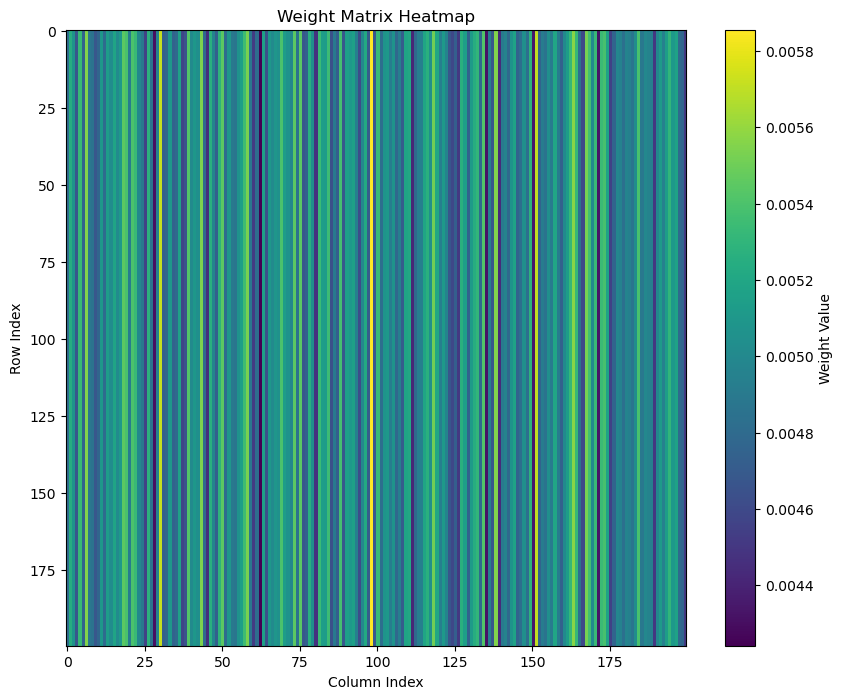

In [115]:
def generate_heatmap(weight_matrix):
    """
    Generates a heatmap from a given weight matrix.
    
    Parameters:
    weight_matrix (numpy.ndarray): A 2D numpy array of shape (200, 200) representing the weights.
    
    Returns:
    None
    """
    if weight_matrix.shape != (200, 200):
        raise ValueError("The weight matrix must be of shape (200, 200)")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(weight_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weight Matrix Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Example usage
#caw = decoder_weights.cpu().detach().numpy()
generate_heatmap(caw)

## With feed-forward network
The way it is implemented in the masked nlp paper

In [116]:
# Sequences for decoder
dec_chains_train = np.load('final_chains_T=1_num_iters=20_J_experiment_train.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('final_chains_T=1_num_iters=20_J_experiment_test.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)

batch_size = 32
train_loader, test_loader = create_dataloaders(dec_chains_train, dec_chains_test, batch_size)

FileNotFoundError: [Errno 2] No such file or directory: 'final_chains_T=1_num_iters=20_J_experiment_train.npy'

In [117]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)
        output = self.fc(self.dropout(attn_output))
        return output, scores

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_hidden):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [118]:
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(SimpleTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a
        self.feed_forward = PositionWiseFeedForward(embed_dim, hidden_dim)
        self.attention = VanillaAttentionTransformer(embed_dim, a, max_seq_length, num_spins, dropout_rate)
    
    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)
        batch_size, seq_length, num_features = s.shape
        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)
        x = self.word_embeddings(s) + self.a * position_embeddings
        x, attn_weights = self.attention(x)
        output = self.feed_forward(x)
        return output, attn_weights


In [119]:
def evaluate(model, test_loader, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding_batch(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins_batch(input_seq, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
        positions = positions.squeeze(-1)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)
        predictions = [outputs[i][positions[i]] for i in range(positions.shape[0])]
        predictions = torch.stack(predictions)
        
        target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
        target_tokens = torch.stack(target_tokens)
        target_tokens = torch.where(target_tokens==1)[1]

        # Compute loss
        loss = criterion(predictions, target_tokens)
        epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(test_loader)

def train(model, train_loader, test_loader, vocab, optimizer, criterion, num_epochs=50, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            input_one_hot = one_hot_encoding_batch(data, vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins_batch(data, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
            target_tokens = torch.stack(target_tokens)
            target_tokens = torch.where(target_tokens==1)[1]
            predictions = [prediction[i][positions[i]] for i in range(positions.shape[0])]
            predictions = torch.stack(predictions)
            # Compute loss
            loss = criterion(predictions, target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [120]:
# Define the parameters 
vocab_size = 3
vocab = {-1:0,1:1,2:2} 
L = 200
embedding_dim = 20
hidden_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [121]:
# Example usage:
model = SimpleTransformer(embed_dim=embedding_dim, hidden_dim=hidden_dim, a=1, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, test_loader, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 2.1679


  2%|▏         | 1/50 [00:04<03:43,  4.56s/it]

Epoch 1 | Eval Loss: 0.1015


Epoch 2 | Train Loss: 0.8302


  4%|▍         | 2/50 [00:08<03:34,  4.47s/it]

Epoch 2 | Eval Loss: 0.0280


Epoch 3 | Train Loss: 0.9009


  6%|▌         | 3/50 [00:13<03:28,  4.45s/it]

Epoch 3 | Eval Loss: 0.0407


Epoch 4 | Train Loss: 0.8010


  8%|▊         | 4/50 [00:17<03:24,  4.45s/it]

Epoch 4 | Eval Loss: 0.0672


Epoch 5 | Train Loss: 0.6917


 10%|█         | 5/50 [00:22<03:20,  4.44s/it]

Epoch 5 | Eval Loss: 0.0403


Epoch 6 | Train Loss: 0.9419


 12%|█▏        | 6/50 [00:26<03:17,  4.49s/it]

Epoch 6 | Eval Loss: 0.0281


Epoch 7 | Train Loss: 0.6932


 14%|█▍        | 7/50 [00:31<03:11,  4.46s/it]

Epoch 7 | Eval Loss: 0.0107


Epoch 8 | Train Loss: 0.6428


 16%|█▌        | 8/50 [00:35<03:06,  4.44s/it]

Epoch 8 | Eval Loss: 0.0531


Epoch 9 | Train Loss: 0.6297


 18%|█▊        | 9/50 [00:40<03:01,  4.43s/it]

Epoch 9 | Eval Loss: 0.0745


Epoch 10 | Train Loss: 0.7161


 20%|██        | 10/50 [00:44<02:57,  4.43s/it]

Epoch 10 | Eval Loss: 0.0480


Epoch 11 | Train Loss: 0.5571


 22%|██▏       | 11/50 [00:48<02:53,  4.45s/it]

Epoch 11 | Eval Loss: 0.0180


Epoch 12 | Train Loss: 0.5867


 24%|██▍       | 12/50 [00:53<02:49,  4.45s/it]

Epoch 12 | Eval Loss: 0.0342


Epoch 13 | Train Loss: 0.7051


 26%|██▌       | 13/50 [00:57<02:45,  4.47s/it]

Epoch 13 | Eval Loss: 0.0631


Epoch 14 | Train Loss: 0.8500


 28%|██▊       | 14/50 [01:02<02:40,  4.47s/it]

Epoch 14 | Eval Loss: 0.0940


Epoch 15 | Train Loss: 0.8356


 30%|███       | 15/50 [01:06<02:36,  4.46s/it]

Epoch 15 | Eval Loss: 0.0359


Epoch 16 | Train Loss: 0.5374


 32%|███▏      | 16/50 [01:11<02:31,  4.46s/it]

Epoch 16 | Eval Loss: 0.0253


Epoch 17 | Train Loss: 0.6314


 34%|███▍      | 17/50 [01:15<02:27,  4.48s/it]

Epoch 17 | Eval Loss: 0.0359


Epoch 18 | Train Loss: 0.6201


 36%|███▌      | 18/50 [01:20<02:23,  4.49s/it]

Epoch 18 | Eval Loss: 0.0868


Epoch 19 | Train Loss: 0.6529


 38%|███▊      | 19/50 [01:24<02:19,  4.51s/it]

Epoch 19 | Eval Loss: 0.0516


Epoch 20 | Train Loss: 0.6904


 40%|████      | 20/50 [01:29<02:14,  4.49s/it]

Epoch 20 | Eval Loss: 0.0530


Epoch 21 | Train Loss: 0.6136


 42%|████▏     | 21/50 [01:33<02:10,  4.50s/it]

Epoch 21 | Eval Loss: 0.0217


Epoch 22 | Train Loss: 0.7420


 44%|████▍     | 22/50 [01:38<02:05,  4.49s/it]

Epoch 22 | Eval Loss: 0.0254


Epoch 23 | Train Loss: 0.5325


 46%|████▌     | 23/50 [01:42<02:01,  4.48s/it]

Epoch 23 | Eval Loss: 0.0252


Epoch 24 | Train Loss: 0.5184


 48%|████▊     | 24/50 [01:47<01:56,  4.47s/it]

Epoch 24 | Eval Loss: 0.0182


Epoch 25 | Train Loss: 0.4540


 50%|█████     | 25/50 [01:51<01:52,  4.48s/it]

Epoch 25 | Eval Loss: 0.0204


Epoch 26 | Train Loss: 0.6625


 52%|█████▏    | 26/50 [01:56<01:47,  4.48s/it]

Epoch 26 | Eval Loss: 0.0390


Epoch 27 | Train Loss: 0.5909


 54%|█████▍    | 27/50 [02:00<01:42,  4.48s/it]

Epoch 27 | Eval Loss: 0.0512


Epoch 28 | Train Loss: 0.6274


 56%|█████▌    | 28/50 [02:05<01:38,  4.50s/it]

Epoch 28 | Eval Loss: 0.0160


Epoch 29 | Train Loss: 0.5641


 58%|█████▊    | 29/50 [02:09<01:35,  4.53s/it]

Epoch 29 | Eval Loss: 0.0119


Epoch 30 | Train Loss: 0.7124


 60%|██████    | 30/50 [02:14<01:30,  4.51s/it]

Epoch 30 | Eval Loss: 0.0289


Epoch 31 | Train Loss: 0.5671


 62%|██████▏   | 31/50 [02:18<01:25,  4.53s/it]

Epoch 31 | Eval Loss: 0.0374


Epoch 32 | Train Loss: 0.5418


 64%|██████▍   | 32/50 [02:23<01:20,  4.50s/it]

Epoch 32 | Eval Loss: 0.0142


Epoch 33 | Train Loss: 0.7894


 66%|██████▌   | 33/50 [02:27<01:16,  4.49s/it]

Epoch 33 | Eval Loss: 0.0303


Epoch 34 | Train Loss: 0.4710


 68%|██████▊   | 34/50 [02:32<01:11,  4.47s/it]

Epoch 34 | Eval Loss: 0.0250


Epoch 35 | Train Loss: 0.7110


 70%|███████   | 35/50 [02:36<01:06,  4.46s/it]

Epoch 35 | Eval Loss: 0.0224


Epoch 36 | Train Loss: 0.5403


 72%|███████▏  | 36/50 [02:41<01:02,  4.47s/it]

Epoch 36 | Eval Loss: 0.0279


Epoch 37 | Train Loss: 0.7382


 74%|███████▍  | 37/50 [02:45<00:57,  4.46s/it]

Epoch 37 | Eval Loss: 0.0637


Epoch 38 | Train Loss: 0.6139


 76%|███████▌  | 38/50 [02:50<00:53,  4.47s/it]

Epoch 38 | Eval Loss: 0.0231


Epoch 39 | Train Loss: 0.7791


 78%|███████▊  | 39/50 [02:54<00:49,  4.47s/it]

Epoch 39 | Eval Loss: 0.0452


Epoch 40 | Train Loss: 0.5835


 80%|████████  | 40/50 [02:58<00:44,  4.47s/it]

Epoch 40 | Eval Loss: 0.0274


Epoch 41 | Train Loss: 0.5257


 82%|████████▏ | 41/50 [03:03<00:40,  4.47s/it]

Epoch 41 | Eval Loss: 0.0335


Epoch 42 | Train Loss: 0.6794


 84%|████████▍ | 42/50 [03:07<00:35,  4.48s/it]

Epoch 42 | Eval Loss: 0.0580


Epoch 43 | Train Loss: 0.7504


 86%|████████▌ | 43/50 [03:12<00:31,  4.52s/it]

Epoch 43 | Eval Loss: 0.0593


Epoch 44 | Train Loss: 0.6924


 88%|████████▊ | 44/50 [03:17<00:27,  4.51s/it]

Epoch 44 | Eval Loss: 0.0477


Epoch 45 | Train Loss: 0.6186


 90%|█████████ | 45/50 [03:21<00:22,  4.49s/it]

Epoch 45 | Eval Loss: 0.0342


Epoch 46 | Train Loss: 0.7113


 92%|█████████▏| 46/50 [03:25<00:17,  4.49s/it]

Epoch 46 | Eval Loss: 0.0238


Epoch 47 | Train Loss: 0.5523


 94%|█████████▍| 47/50 [03:30<00:13,  4.47s/it]

Epoch 47 | Eval Loss: 0.0554


Epoch 48 | Train Loss: 0.7504


 96%|█████████▌| 48/50 [03:34<00:08,  4.47s/it]

Epoch 48 | Eval Loss: 0.0332


Epoch 49 | Train Loss: 0.5104


 98%|█████████▊| 49/50 [03:39<00:04,  4.47s/it]

Epoch 49 | Eval Loss: 0.0508


Epoch 50 | Train Loss: 0.7164


100%|██████████| 32/32 [00:02<00:00, 15.77it/s]
                                               

Epoch 50 | Eval Loss: 0.0285


In [122]:
attn_weights = torch.vstack(attn_weights)
# To save only the decoder layer weights
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(dec_chains_test.shape)

torch.Size([1000, 200, 200])
(1000, 200)


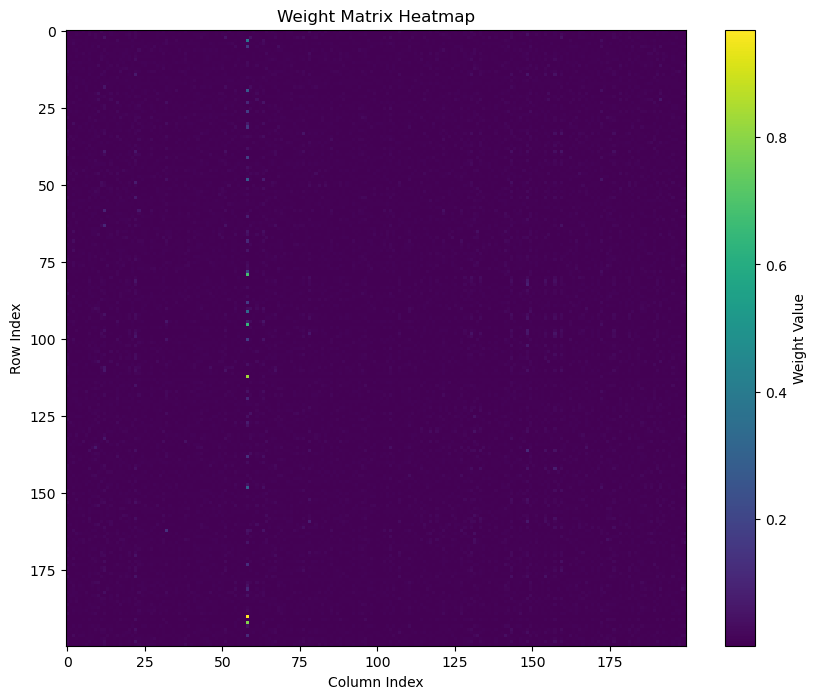

In [127]:
caw = decoder_weights[-100].cpu().detach().numpy()
generate_heatmap(caw)

To fully reproduce results we should consider vocabulary of 20 (equal to number of amino acids)

## Previous implementations

In [198]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        s = torch.tensor(s, dtype=torch.float)
        masked_token = torch.tensor(masked_token, dtype=torch.float)
        #print("the sequence with the masked token:", s)
        print("shape of position ids before embedding:", position_ids.shape)
        print("shape the sequence with the masked token:", s.shape)
        print("value of the word embedding:", self.word_embeddings(s).shape)
        print("positional embedding:", self.position_embeddings(position_ids))
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)) # (batch_size,embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.dropout(self.fc(attn_output))
        return output
    
class FactoredAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(FactoredAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins, embed_dim)
        self.word_embedding.weight.requires_grad = False
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        # masked token should be equal to 0
        # masked_token = torch.tensor([0])
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s)) # (embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.fc(self.dropout(attn_output))
        return output